# RC3DR
Robot-controlled 3D Reconstruction


This project is heavily based on the following two papers:
- Xinyi Fan, Linguang Zhang, Benedict Brown, and Szymon Rusinkiewicz. 2016. Automated view and path planning for scalable multi-object 3D scanning. ACM Trans. Graph. 35, 6, Article 239 (November 2016), 13 pages. DOI:https://doi.org/10.1145/2980179.2980225
- R. A. Newcombe et al., "KinectFusion: Real-time dense surface mapping and tracking," 2011 10th IEEE International Symposium on Mixed and Augmented Reality, Basel, 2011, pp. 127-136.


## *Required packages*:
- numpy
- scipy
- numba
- python-socketio
- tornado
- skimage
- igl
- pyquaternion

![blubb](res/Poster.jpg)

## Setup

This project uses modern web technologies to interact with the program instead of traditional GUI frameworks. In the future, it should be possible to work from any mobile device at any location and share results with the world quickly and without any setup.

First, we have to start the server:

In [1]:
# Imports

# Server
import asyncio # event loop
from dash import Dash # Web-App

# rc3dr
from rc3dr import rc3dr, utils, view_traversal

# processing
import numpy as np
import scipy as sp
import igl

# cuda kernel
from numba import cuda
import math

# plotting
import ipyvolume as ipv
import matplotlib.pyplot as plt 


In [2]:
# specify port on where to run the server
port = 8005
# initialize Dash
dash = Dash(port) 

# Since this notebook runs on an event loop we have to create a seperate task for the server
loop = asyncio.get_event_loop()
async def start_server(dash):
    dash.start_server()
loop.create_task(start_server(dash)) # Coroutine gets killed as soon as kernel of this notebook stops

<Task pending coro=<start_server() running at <ipython-input-2-efda0c35c066>:8>>

======== Running on http://0.0.0.0:8005 ========
Press CTRL+C to quit
I'm connected!
I'm connected!
fuse
fuse
fuse
fuse
fuse
explore
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse
fuse


Next, go to *localhost:port*. You should see something like this:

<img src="./res/dash-image.jpg" height=60>

## Let's start

On the *Dash* we can take various *actions* that lead us through the 3D reconstruction pipeline:

- **Start TSDF**: Start capturing depth images and send those to the server. On the server we compute a *truncated signed distance function (TSDF)* from the depth image and *fuse* it together with the TSDFs obtained from previous depth images.
- **Start exploration**: The 3D reconstruction pipeline starts with a scene exploration step to capture an initial 3D estimate of the target object. In the subsequent steps, we use this information to compute views that heuristically contain the most information about the object.
- **Sample views**: We compute those views by first sampling views on a sphere around the object in order to keep a save distance from the camera.
- **Select views**: Next, we select a minimal subset of those views that together contain the most information about the object. This step has multiple substeps: First, we reconstruct a mesh from the TSDF (marching cubes) and process the resulting mesh (smoothing). Second, we compute the curvature for each vertex in the mesh and sample vertices weighted by their curvature. This gives more weight to surface areas that contain more details. In the third step, we compute for each view and each sampled vertex a *geometry score* (angle between ray from vertex to camera and surface normal) and a *visibility value* (1 if in view space, 0 otherwise). Finally, we successively select views that improve the objective function $f(min\ subset)$ most at each iteration (we terminate if there is no further improvement). 
$$ f(\text{min subset}) = \sum_{p\ \in\ \text{sampled vertices}}{max_{v\ \in\ \text{min subset}}{\text{geometry}(p,v) \cdot \text{visibility}(p,v)}} - \gamma \cdot \vert \text{min subset} \vert$$
Note, that the set-cover problem is NP-complete and in most cases requires approximating algorithms.
- **Traverse views**: We are left with finding the shortest path that connects our chosen views. This corresponds to the travelling salesman problem that is NP-hard. Here, we use a greedy approach and select at each step the view that is nearest to the current one. We define the distance $d(a,b)$ between two views $a$ and $b$ as $ d(a,b)= \max{\vert q_a - q_b \vert} $, where $q_a$ and $q_b$ are the robot generalized coordinates for views $a$ and $b$ (in our case the angles of the revolute joints).
- **Flip volume**: Rotate the TSDF volume and target object by 180 degree around the y-axis. This very naively emulates a second robot arm that can pick the target object from the other side.

Now it's time to experiment. Press **Start TSDF** and then **Start exploration**. After the robot completeted its movement press **Stop TSDF** and execute the subsequent cell.

In [12]:
F = dash.rc3dr.get_tsdf_volume()
verts, faces = dash.rc3dr.view_selector.tsdf_to_mesh(F)

ipv.figure()
mesh = ipv.plot_trisurf(verts[:,0], verts[:,1], verts[:,2], triangles=faces, color='violet')
ipv.squarelim()
ipv.show()

We can also inspect the TSDF directly:

In [8]:
# Try to update slider of first level.
# NOTE Widget needs some time to load.
ipv.quickvolshow(F, level=0, opacity=1, level_width=0.1, data_min=-1, data_max=1)

/home/bigboy/anaconda3/envs/tensorflow_2/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


Now go to the *Dash* and click you through the 3D reconstruction pipeline detailed above. Don't forget to start/stop the depth image recording. Then execute the cells again.

## Code Details

The RC3DR code is structured into following files:
- rc3dr.py: Store data (e.g. TSDF, robot etc.) and handle IO.
- fusion.py: TSDF fusion.
- object_exploration.py: Generate object exploration steps.
- view_sampling.py: Sample views.
- view_selection.py: Select views.
- view_traversal.py: Generate view traversal steps.
- parameters.py: Contains all parameters needed for the files above.
- utils.py: Utility functions.
- kinematics.py: Contains inverse kinematic solver.

In order to demonstrate the code in a more understandable way, let's go through the 3D reconstruction pipeline again but instead of clicking the buttons on the *Dash* we call the functions from this notebook directly.  

### View sampling

In [9]:
# View sampling
views = dash.rc3dr.view_sampler.sample_views()
num_views = len(views)

### View selection

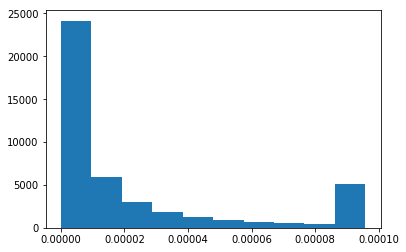

In [10]:
# View selection - part 1

# 1) TSDF to mesh
F = dash.rc3dr.get_tsdf_volume()
verts, faces = dash.rc3dr.view_selector.tsdf_to_mesh(F)

# 2) Process mesh to get proper surface normals -> smooth mesh
# NOTE w depends on mesh size
w = 1e8
v_star = utils.smooth_data(verts, faces, 1e8)

# 3) Sample vertices from mesh weighted by curvature
verts_choice, p = dash.rc3dr.view_selector.sample_verts_from_mesh(v_star, faces)
normals = igl.per_vertex_normals(v_star, faces)
# Note take unprocessed vertices
verts_sam = verts[verts_choice,:]
normals_sam = normals[verts_choice,:]

plt.hist(p)

ipv.figure()
color = np.ones((v_star.shape[0], 3)) * np.expand_dims(p, axis=1) / np.max(p) + np.array([[0.5, 0,0.5]])
mesh = ipv.plot_trisurf(v_star[:,0], v_star[:,1], v_star[:,2], triangles=faces, color=color)
ipv.squarelim()
ipv.show()

In [11]:
# View selection - part 2

# 4) Geometry values
# Here we compute the scores for points of just one view
view = [0,0, 0.75, 0, 1, 0, np.pi] # view[:3] = position, view[3:6] = rotation aixs, view[6] = angle
# NOTE points outside view frustum get score = 0
scores = dash.rc3dr.view_selector.compute_geometry_values(view, verts_sam, normals_sam)

color = np.zeros((scores.shape[0],3))
color[:,0] = scores

plot_pts = np.vstack([verts_sam, np.array(view[:3])])
plot_colors = np.vstack([color, np.array([1, 0, 0])])

size = np.ones(plot_pts.shape[0])
size[-1] = 2
ipv.quickscatter(plot_pts[:,0], plot_pts[:,2], plot_pts[:,1], color = plot_colors, size=size, marker="sphere")

In [12]:
# View selection - part 3

# 5) Visibility values


# The follwing function gets compiled to a cuda kernel. We use this function to track rays
@cuda.jit
def check_visibility_track_rays(track_rays, visibility, view_pos, points, tsdf_volume, K, voxel_size, mu):
    """
    Args:
        view: e_T_c (projection from camera view to end-effector)
        points: points expressed in end-effector system. (n_points, 3)
    """
    start_x = cuda.grid(1)
    stride_x = cuda.gridsize(1)
    
    for i in range(start_x, points.shape[0], stride_x):
        # ray marching from point to camera
        # check if visible
        
        ray_point_x = points[i,0]
        ray_point_y = points[i,1]
        ray_point_z = points[i,2]
        
        ray_direction_x = view_pos[0] - points[i,0]
        ray_direction_y = view_pos[1] - points[i,1]
        ray_direction_z = view_pos[2] - points[i,2]
        
        # normalize ray direction
        ray_norm = math.sqrt(ray_direction_x**2 + ray_direction_y**2 + ray_direction_z**2)
        ray_direction_x /= ray_norm
        ray_direction_y /= ray_norm
        ray_direction_z /= ray_norm
        
        # NOTE Assumes quadratic volume
        tsdf_dim = voxel_size * tsdf_volume.shape[0]
        
        while True:
            # go in ray direction
            ray_point_x += mu * ray_direction_x
            ray_point_y += mu * ray_direction_y
            ray_point_z += mu * ray_direction_z
            
            # get volume coordinates
            tmp = ((ray_point_x + tsdf_dim / 2) / tsdf_dim) * tsdf_volume.shape[0]
            v_x = int(math.floor(tmp))
            tmp = ((ray_point_y + tsdf_dim / 2) / tsdf_dim) * tsdf_volume.shape[0]
            v_y = int(math.floor(tmp))
            tmp = ((ray_point_z + tsdf_dim / 2) / tsdf_dim) * tsdf_volume.shape[0]
            v_z = int(math.floor(tmp))
            
            if (v_x < 0 or v_x >= tsdf_volume.shape[0] 
                or v_y < 0 or v_y >= tsdf_volume.shape[1] 
                or v_z < 0 or v_z >= tsdf_volume.shape[2]):
                visibility[i] = 1
                break
                
            tsdf_value = tsdf_volume[v_x, v_y, v_z]
            track_rays[v_x, v_y, v_z] = 1
            
            if tsdf_value <= 0:
                visibility[i] = 0
                break

In [13]:
visibility = np.zeros(verts_sam.shape[0])
track_rays = np.zeros(F.shape)
mu = rc3dr.tsdf_vol_params.voxel_size * np.sqrt(3)
#execute kernel with 30 block each 128 threas
check_visibility_track_rays[30,128](track_rays, 
                                    visibility, 
                                    np.array(view[:3]), 
                                    verts_sam, 
                                    F, 
                                    rc3dr.cam_params.K, 
                                    rc3dr.tsdf_vol_params.voxel_size, 
                                    mu)

In [14]:
# visualize rays
ipv.quickvolshow(track_rays, level=1, opacity=1, level_width=0.1, data_min=0, data_max= 1)

/home/bigboy/anaconda3/envs/tensorflow_2/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [15]:
# visual visible points

color = np.zeros((visibility.shape[0],3))
color[:,0] = visibility
plot_colors = np.vstack([color, np.array([1, 0, 0])])

ipv.quickscatter(plot_pts[:,0], plot_pts[:,2], plot_pts[:,1], color = plot_colors, size=size, marker="sphere")

In [16]:
# View selection - part 4

# 6) Greedy selection
scores = np.ndarray((num_views, verts_sam.shape[0]))
for i in range(num_views):
    scores[i,:] = dash.rc3dr.view_selector.compute_geometry_values(views[i], verts_sam, normals_sam)
    visibility = dash.rc3dr.view_selector.compute_visibility_values(views[i], verts_sam, F)
    scores[i,:] *= visibility
    
best_views, total_score = dash.rc3dr.view_selector.greedy_best_subset(scores)

print("Total score: %f" % (total_score))
print("Best views: \n", best_views)

Total score: 610.378022
Best views: 
 [99, 39, 9, 15, 23, 62]


In [17]:
# Visualization
f_T_e = np.linalg.inv(rc3dr.tsdf_vol_params.e_T_f)
views_f = utils.views_e_to_f(views, f_T_e)
cam_poses = utils.views_to_cam_poses(views_f)

ipv.figure()
quiver = ipv.quiver(cam_poses[best_views,0], cam_poses[best_views,1], cam_poses[best_views,2], cam_poses[best_views,3], cam_poses[best_views,4], cam_poses[best_views,5], size=6, color=(0,1,0))
quiver = ipv.quiver(cam_poses[:,0], cam_poses[:,1], cam_poses[:,2], cam_poses[:,3], cam_poses[:,4], cam_poses[:,5], size=5)

scatter = ipv.scatter(verts_sam[:,0], verts_sam[:,1], verts_sam[:,2], size=1, marker="sphere")
ipv.squarelim()
ipv.show()

### View traversal

In [18]:
view_traverser = view_traversal.ViewTraverser(rc3dr.view_traverser_params, 
                                              rc3dr.cam_params, 
                                              rc3dr.tsdf_vol_params)

In [19]:
# NOTE Multiple users can connect to the dash
# For each user we save data such as TSDF/ robot/ etc.
user_sid = list(dash.rc3dr.user_sids)[-1]
print(user_sid)

robot = dash.rc3dr.robot_map[user_sid]
ee_id = robot.index(dash.rc3dr.ee_name)
inv_kin_solver = dash.rc3dr.inv_kin_solver

views_best = np.array(views)[best_views,:].tolist()

q_steps, greedy_traversal, view_steps_e = view_traverser.get_steps(views_best, robot, ee_id, inv_kin_solver)

9f426fee76e044299d7c44908db65364
Views to generalized coords...
Compute greedy shortest path...
Compute steps...


In [20]:
view_steps_f = utils.views_e_to_f(view_steps_e, f_T_e)
cam_pose_steps = utils.views_to_cam_poses(view_steps_f)

ipv.figure()
quiver = ipv.quiver(cam_poses[best_views,0], cam_poses[best_views,1], cam_poses[best_views,2], cam_poses[best_views,3], cam_poses[best_views,4], cam_poses[best_views,5], size=10, color=(0,1,0))
quiver = ipv.quiver(cam_pose_steps[:,0], cam_pose_steps[:,1], cam_pose_steps[:,2], cam_pose_steps[:,3], cam_pose_steps[:,4], cam_pose_steps[:,5], size=5)

scatter = ipv.scatter(verts_sam[:,0], verts_sam[:,1], verts_sam[:,2], size=1, marker="sphere")
ipv.squarelim()
ipv.show()

## TODOs

- Convert 8-bit depth channel to RGB or single float channel. (At the moment the depth channel can only take 255 values. However, the depth channel has higher resolution at near distance than at far distance).
- Improve view sampling
- Improve path trajectory planning
- Implement framework in C++
- ...

## Conclusions

This project presents a complete solution for the robot-guided 3D reconstruction (RC3DR) process in simulation. In a next step, we want to evaluate this framework in the real world.